Pronóstico de la popularidad de libros
===

* *30 min* | Ultima modificación: Junio 22, 2019

## Descripción del problema

La editorial O'Really desea construir una herramienta analítica que le permita a un editor estimar la popularidad relativa de un nuevo libro antes de su lanzamiento, con el fin de poder priorizar los títulos a publicar e inclusive rechazar posibles proyectos editoriales. 

Para resolver este problema se tiene una base de datos con los 100 libros más vendidos por O'Really durante el año 2011. La base contiene el título del libro, su descripción y su ranking en pupularidad. Para este caso se hipotetiza que la aparición de ciertas palabras en la descripción del libro permitirá determinar su popularidad.

## Preparación

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

## Lectura de datos

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/oreilly.csv",
    sep = ',',           # separador de campos
    thousands = None,    # separador de miles para números
    decimal = '.',       # separador de los decimales para números
    encoding='latin-1')  # idioma

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
IP_Family     100 non-null object
BOOK title    100 non-null object
BOOK ISBN     100 non-null int64
Rank          100 non-null int64
Long Desc.    100 non-null object
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


## Construcción de la matriz de términos del documento

In [3]:
##
## Matriz de términos del documento
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    min_df=5)               # ignora palabras con baja freq

##
## Aplica la función al texto
##
df_dtm = count_vect.fit_transform(df['Long Desc.'])

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
df_dtm.shape

(100, 636)

In [4]:
X = df_dtm.toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 2, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Modelo de regresión logística

In [19]:
y = np.array([1] * 50 + [0]*50)

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    solver='lbfgs', 
    multi_class='auto',
    max_iter = 1000)

clf.fit(X, y)
y_pred = clf.predict(X)

In [22]:
%%R -i y -i y_pred
##
## La función CrossTable del paquete gmodels
## entrega información más detallada.
## install.packages("gmodels")
##
library(gmodels)
CrossTable(
    x = y, 
    y = y_pred,
    prop.chisq=FALSE)


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  100 

 
             | y_pred 
           y |         0 |         1 | Row Total | 
-------------|-----------|-----------|-----------|
           0 |        50 |         0 |        50 | 
             |     1.000 |     0.000 |     0.500 | 
             |     1.000 |     0.000 |           | 
             |     0.500 |     0.000 |           | 
-------------|-----------|-----------|-----------|
           1 |         0 |        50 |        50 | 
             |     0.000 |     1.000 |     0.500 | 
             |     0.000 |     1.000 |           | 
             |     0.000 |     0.500 |           | 
-------------|-----------|-----------|-----------|
Column Total |        50 |        50 |       100 | 
             |     0.500 |     0.500 |           | 
-------------|---------

## Apéndice --- Lenguaje R

In [25]:
%%sh
PACK=glmnet
if /usr/bin/test ! -d /usr/local/lib/R/site-library/$PACK; 
then    
    sudo Rscript -e 'install.packages("'$PACK'")'
fi

In [26]:
%%R 
## Carga y verificación de los datos
ranks <- read.csv('oreilly.csv', stringsAsFactors = FALSE)
str(ranks)

'data.frame':	100 obs. of  5 variables:
 $ IP_Family : chr  "9780596000271.IP" "9781565923928.IP" "9780596007126.IP" "9780596009205.IP" ...
 $ BOOK.title: chr  "Programming Perl, 3E" "Javascript: The Definitive Guide, 3E" "Head First Design Patterns" "Head First Java, 2E" ...
 $ BOOK.ISBN : num  9.78e+12 9.78e+12 9.78e+12 9.78e+12 9.78e+12 ...
 $ Rank      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Long.Desc.: chr  "Perl is a powerful programming language that  has grown in popularity since it first appeared in 1988. The firs"| __truncated__ "JavaScript is a powerful scripting language that can be embedded directly in HTML. It allows you to create dyna"| __truncated__ "You're not alone.<br />\n<br />\nAt any given moment, somewhere in the world someone struggles with the same so"| __truncated__ "Learning a complex new language is no easy task especially when it s an object-oriented computer programming la"| __truncated__ ...


### Entrenamiento del modelo

In [27]:
%%R
## carga la libreria para text mining
library(tm)

## La clasificación se basa únicamente en la descripción
## y no se tiene en cuenta el título.
documents <- data.frame(doc_id = ranks$BOOK.ISBN, text = ranks$Long.Desc.) 
row.names(documents) <- 1:nrow(documents)

## Crea el corpus y limpia el documento.
corpus <- Corpus(DataframeSource(documents))
corpus <- tm_map(corpus, tolower)
corpus <- tm_map(corpus, stripWhitespace)
corpus <- tm_map(corpus, removeWords, stopwords('english'))

## Crea la matriz de términos
dtm <- DocumentTermMatrix(corpus)

## Obtiene los regresores y la variable independiente.
## La matriz de términos del documento se convierte en
## una matriz numérica para poder realizar la regresión.
x <- as.matrix(dtm) 
y <- rev(1:100)  # 100, 99, ...

Este problema será resuelto como un problema de clasificación. Para ello, se pronosticará si un libro está en el top 50 o no. Nótese que también se podrían formularse otras agrupaciones como el top 10, top 20, etc.

In [28]:
%%R
## Semilla del generador de aleatorios.
set.seed(1)      

## Regresión con regularización.
library(glmnet)

## La variable y indica si el libro pertence (1) o no pertenece (2)
## al top 50 de los libros. A continuación se genera un vector con
## 50 unos y 50 ceros.
y <- rep(c(1, 0), each = 50)

## Crea un data.frame vacío para almacenar los resultados
## de la regresión para diferentes parámetros.
performance <- data.frame()

## Itera sobre diferentes valores de lambda.
for (i in 1:50) 
{
    ## Divide aleatoriamente el conjunto de datos
    ## en una muestra para el entrenamiento y otra
    ## para prueba
    indices <- sample(1:100, 80) 
    training.x <- x[indices, ] 
    training.y <- y[indices]
    
    test.x <- x[-indices, ] 
    test.y <- y[-indices]
    
    ## Realiza la regresión logística para diferentes 
    ## valores de lambda.   
    for (lambda in c(0.0001, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.5, 1)) 
    {
        ## Realiza la regresión.
        glm.fit <- glmnet(training.x, training.y, family = 'binomial')
        
        ## Pronóstico para la muestra de entrenamiento
        predicted.y <- predict(glm.fit, test.x, s = lambda) 
        
        ## Convierte el valor pronósticado en 0=no pertenece, 1=si pertenece.
        predicted.y = ifelse(predicted.y > 0, 1, 0)
        
        ## Métrica de error
        error.rate <- mean(predicted.y != test.y)
        
        ## Almacena el resultado
        performance <- rbind(performance, data.frame(Lambda = lambda, Iteration = i, ErrorRate = error.rate))
    } 
}

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: foreach

R[write to console]: Loaded glmnet 2.0-18




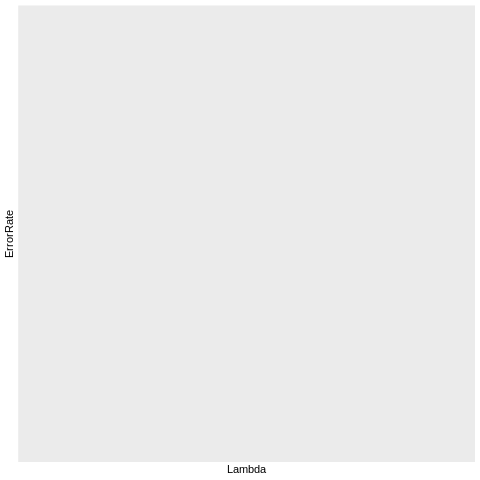

In [29]:
%%R
##
## El resultado de la siguiente gráfica muestra que se obtendría un
## mejor modelo para valores pequeños de lambda
##
library(ggplot2)
ggplot(performance, aes(x = Lambda, y = ErrorRate)) + stat_summary(fun.data = 'mean_cl_boot', geom = 'errorbar') + stat_summary(fun.data = 'mean_cl_boot', geom = 'point') + scale_x_log10()